In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image

In [38]:
image = Image.open('/content/sagar_test.jpg')
mask1 = Image.open('/content/kate_mask.png')

to_tensor = transforms.ToTensor()
image = to_tensor(image).permute(1,2,0)
mask1 = to_tensor(mask1).squeeze(0)
mask1 = mask1.repeat(1,3,1,1).squeeze(0).permute(1,2,0)

In [39]:
image[mask1==0] = 0
mask1[mask1!=0] = 1

#input of our model 
x = image.permute(2,0,1).unsqueeze(0)
mask = mask1.permute(2,0,1).unsqueeze(0)

In [40]:
# plot corrupted image
def plot_priors(x):
    f = plt.figure()
    plt.imshow(x)
    plt.show(block=True)

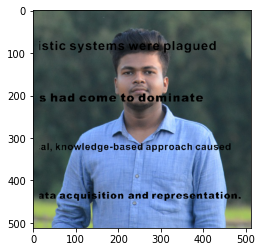

In [41]:
plot_priors(image)

In [42]:
class CNN_Network(nn.Module):
    def __init__(self, z_size):
        super(CNN_Network,self).__init__()

        self.leaky_relu = nn.LeakyReLU()

        self.d_conv_1 = nn.Conv2d(z_size, 8, 5, stride=2, padding=2)
        self.d_bn_1 = nn.BatchNorm2d(8)

        self.d_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.d_bn_2 = nn.BatchNorm2d(16)

        self.d_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.d_bn_3 = nn.BatchNorm2d(32)
        self.s_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)

        self.d_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.d_bn_4 = nn.BatchNorm2d(64)
        self.s_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)

        self.d_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.d_bn_5 = nn.BatchNorm2d(128)
        self.s_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)

        self.d_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.d_bn_6 = nn.BatchNorm2d(256)

        self.u_deconv_5 = nn.ConvTranspose2d(256, 124, 4, stride=2, padding=1)
        self.u_bn_5 = nn.BatchNorm2d(128)

        self.u_deconv_4 = nn.ConvTranspose2d(128, 60, 4, stride=2, padding=1)
        self.u_bn_4 = nn.BatchNorm2d(64)

        self.u_deconv_3 = nn.ConvTranspose2d(64, 28, 4, stride=2, padding=1)
        self.u_bn_3 = nn.BatchNorm2d(32)

        self.u_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.u_bn_2 = nn.BatchNorm2d(16)

        self.u_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.u_bn_1 = nn.BatchNorm2d(8)

        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

    def forward(self, noise):
        down_1 = self.d_conv_1(noise)
        down_1 = self.d_bn_1(down_1)
        down_1 = self.leaky_relu(down_1)

        down_2 = self.d_conv_2(down_1)
        down_2 = self.d_bn_2(down_2)
        down_2 = self.leaky_relu(down_2)

        down_3 = self.d_conv_3(down_2)
        down_3 = self.d_bn_3(down_3)
        down_3 = self.leaky_relu(down_3)
        skip_3 = self.s_conv_3(down_3)

        down_4 = self.d_conv_4(down_3)
        down_4 = self.d_bn_4(down_4)
        down_4 = self.leaky_relu(down_4)
        skip_4 = self.s_conv_4(down_4)

        down_5 = self.d_conv_5(down_4)
        down_5 = self.d_bn_5(down_5)
        down_5 = self.leaky_relu(down_5)
        skip_5 = self.s_conv_5(down_5)

        down_6 = self.d_conv_6(down_5)
        down_6 = self.d_bn_6(down_6)
        down_6 = self.leaky_relu(down_6)

        up_5 = self.u_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5], 1)
        up_5 = self.u_bn_5(up_5)
        up_5 = self.leaky_relu(up_5)

        up_4 = self.u_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4], 1)
        up_4 = self.u_bn_4(up_4)
        up_4 = self.leaky_relu(up_4)

        up_3 = self.u_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3], 1)
        up_3 = self.u_bn_3(up_3)
        up_3 = self.leaky_relu(up_3)

        up_2 = self.u_deconv_2(up_3)
        up_2 = self.u_bn_2(up_2)
        up_2 = self.leaky_relu(up_2)

        up_1 = self.u_deconv_1(up_2)
        up_1 = self.u_bn_1(up_1)
        up_1 = self.leaky_relu(up_1)

        out = self.out_deconv(up_1)
        out = self.out_bn(out)
        out = nn.Sigmoid()(out)

        return out

In [43]:
LM = np.mgrid[:512, :512]/512
LM = torch.from_numpy(LM)

m = LM.unsqueeze(0)
m = m.double()
device = 'cpu'
num_epochs = 3000
lr = 0.02
m_size = m.shape[1]


model = CNN_Network(m_size)
model = model.float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [44]:
plt.savefig("/content/corrupted_img.png", bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [45]:
model = model.to(device)
m = m.to(device)
x = x.to(device)
mask = mask.to(device)

In [46]:
#Training

loss = []
imag = []

for i in range(num_epochs):
    model.zero_grad()
    output = model(m.float())
    L = criterion(x, output*mask)
    loss.append(L.item())
    L.backward()
    optimizer.step()
    
    
    if (i+1)%50 ==0:
        output = model(m.float())
        imag.append(output.squeeze(0).permute(1,2,0))
        
    if (i+1)%100 == 0:
        print('Epoch:', i+1, ',   Error : ', L)

Epoch: 100 ,   Error :  tensor(0.0061, grad_fn=<MseLossBackward0>)
Epoch: 200 ,   Error :  tensor(0.0020, grad_fn=<MseLossBackward0>)
Epoch: 300 ,   Error :  tensor(0.0013, grad_fn=<MseLossBackward0>)
Epoch: 400 ,   Error :  tensor(0.0009, grad_fn=<MseLossBackward0>)
Epoch: 500 ,   Error :  tensor(0.0007, grad_fn=<MseLossBackward0>)
Epoch: 600 ,   Error :  tensor(0.0006, grad_fn=<MseLossBackward0>)
Epoch: 700 ,   Error :  tensor(0.0005, grad_fn=<MseLossBackward0>)
Epoch: 800 ,   Error :  tensor(0.0004, grad_fn=<MseLossBackward0>)
Epoch: 900 ,   Error :  tensor(0.0004, grad_fn=<MseLossBackward0>)
Epoch: 1000 ,   Error :  tensor(0.0003, grad_fn=<MseLossBackward0>)
Epoch: 1100 ,   Error :  tensor(0.0003, grad_fn=<MseLossBackward0>)
Epoch: 1200 ,   Error :  tensor(0.0003, grad_fn=<MseLossBackward0>)
Epoch: 1300 ,   Error :  tensor(0.0003, grad_fn=<MseLossBackward0>)
Epoch: 1400 ,   Error :  tensor(0.0003, grad_fn=<MseLossBackward0>)
Epoch: 1500 ,   Error :  tensor(0.0003, grad_fn=<MseLossB

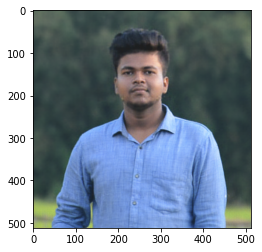

In [49]:
result = model(m.float())

plt.imshow(result.squeeze(0).permute(1,2,0).detach())

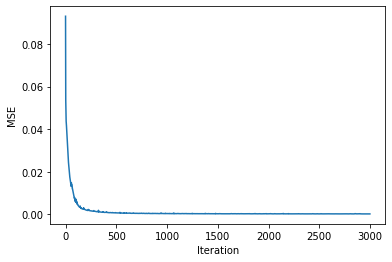

In [50]:
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.plot(loss)